# House prices prediction

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential   
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import missingno as msno

Loading source training data:

In [2]:
house_prices_train = pd.read_csv('./data/train.csv')


Calculating percentage of missing values (NaN):

         Column:  Amount of NaN values:  Percent of NaN values:
0         PoolQC                   1453               99.520548
1    MiscFeature                   1406               96.301370
2          Alley                   1369               93.767123
3          Fence                   1179               80.753425
4    FireplaceQu                    690               47.260274
5    LotFrontage                    259               17.739726
6     GarageType                     81                5.547945
7    GarageYrBlt                     81                5.547945
8   GarageFinish                     81                5.547945
9     GarageQual                     81                5.547945
10    GarageCond                     81                5.547945
11  BsmtExposure                     38                2.602740
12  BsmtFinType2                     38                2.602740
13  BsmtFinType1                     37                2.534247
14      BsmtCond                     37 

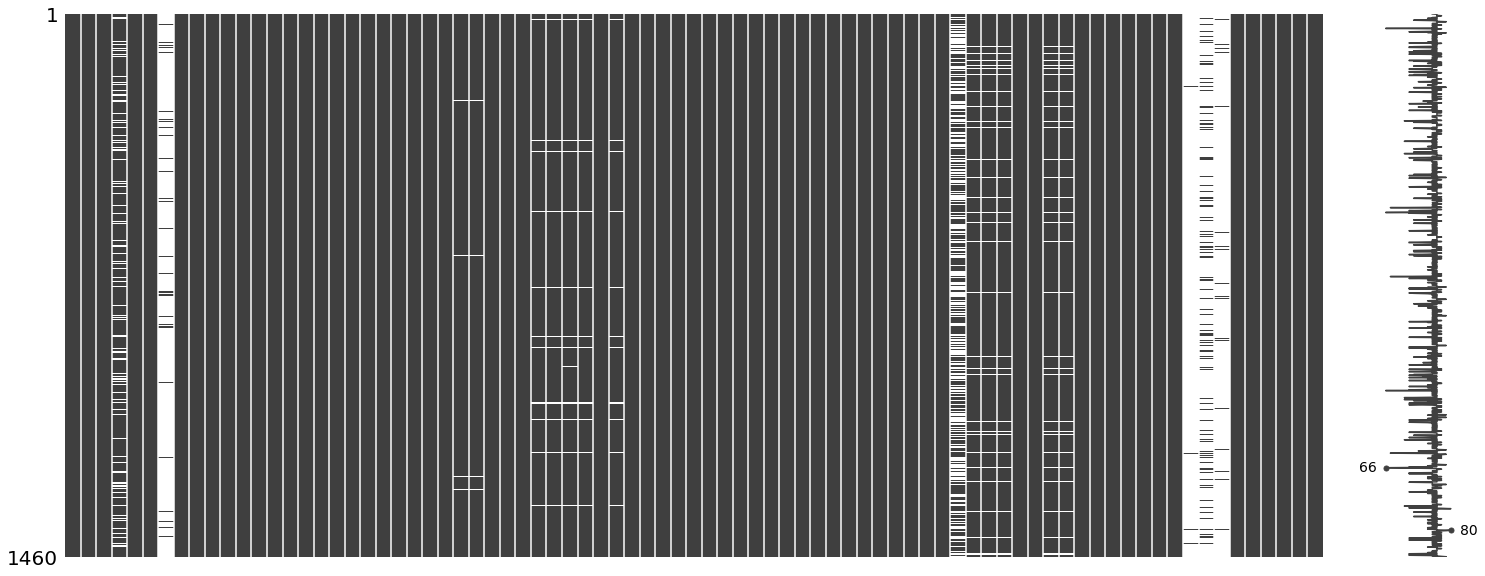

In [3]:
msno.matrix(house_prices_train)
nan_columns = pd.DataFrame({
    'Column:': house_prices_train.columns.values,
    'Amount of NaN values:': house_prices_train.isna().sum().values,
    'Percent of NaN values:': house_prices_train.isna().sum().values * 100 / len(house_prices_train), 
})
nan_columns = nan_columns[nan_columns['Amount of NaN values:'] > 0]
print(nan_columns.sort_values(by='Amount of NaN values:', ascending=False).reset_index(drop=True))


Deleting columns with 40%+ NaN values:

In [4]:
most_nan_columns = nan_columns[nan_columns['Percent of NaN values:'] > 40]
house_prices_train = house_prices_train.drop(list(most_nan_columns['Column:']), axis=1)


Replacing NaN values by values with column type:

<AxesSubplot:>

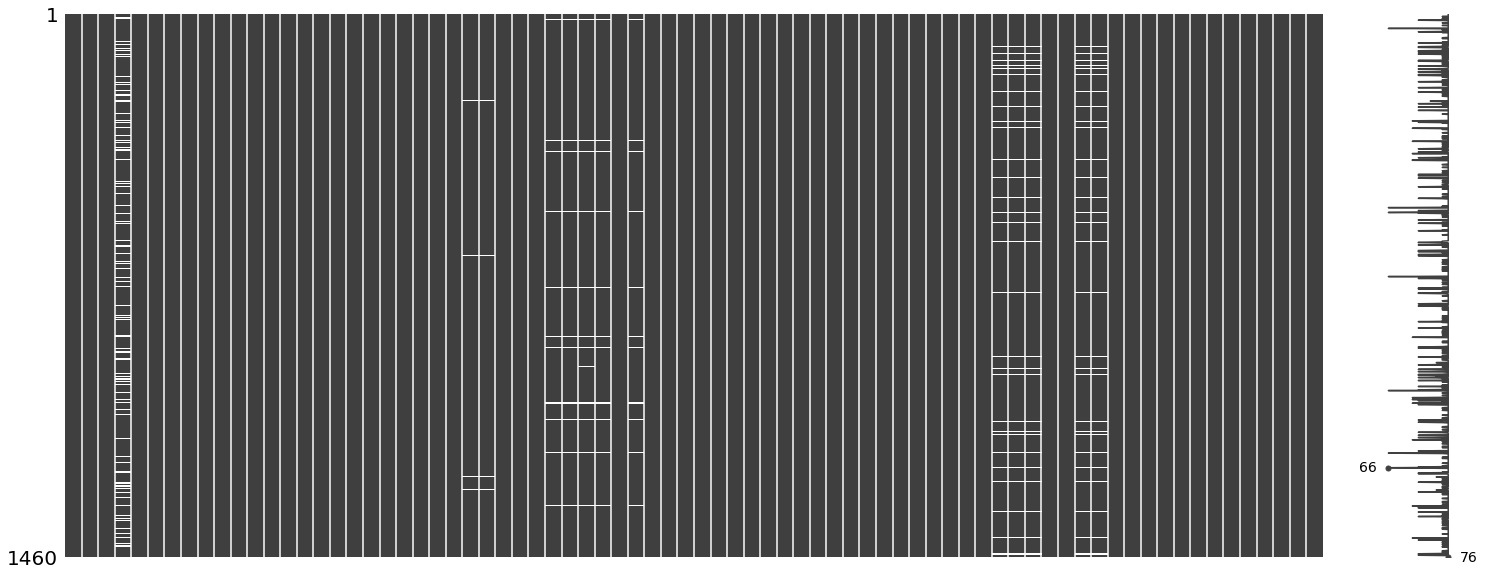

In [5]:
nan_columns = nan_columns[~(nan_columns['Column:'].isin(list(most_nan_columns['Column:'])))]
msno.matrix(house_prices_train)


Replace NaN values in columns (in numerical: by mean value, in categorial: by mode value):

<AxesSubplot:>

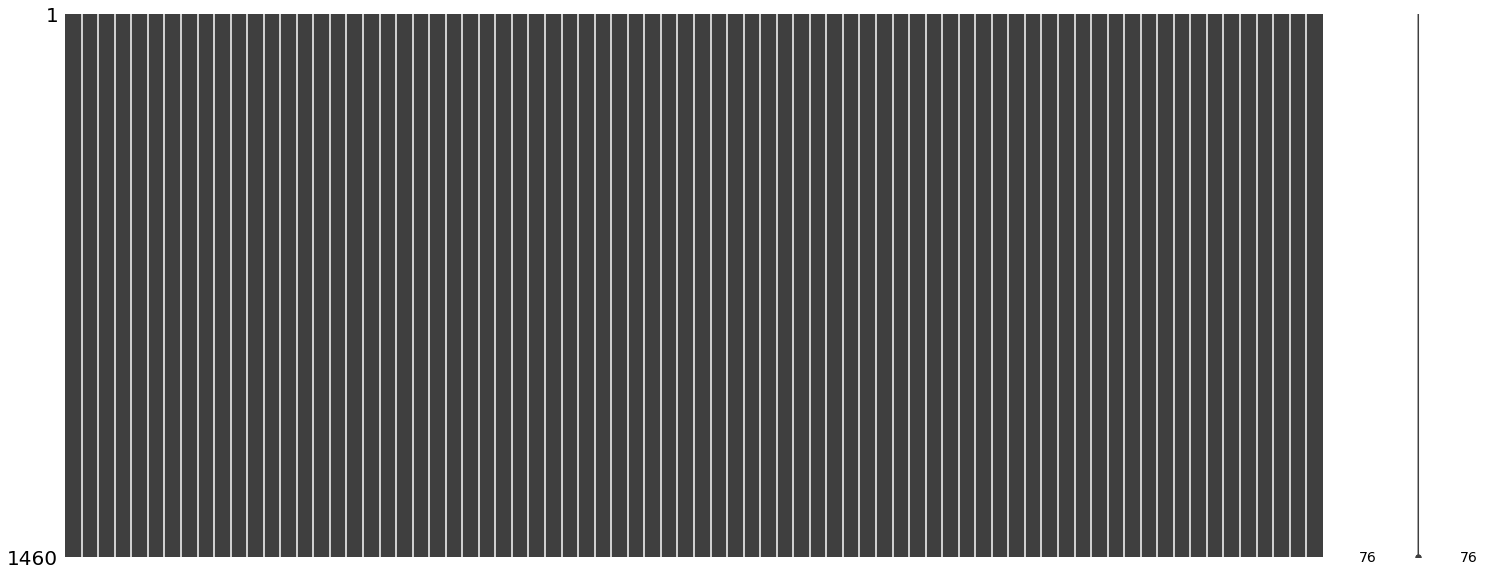

In [6]:
for column in nan_columns['Column:']:
    if house_prices_train[column].dtype == object:
        house_prices_train[column] = house_prices_train[column].fillna(house_prices_train[column].mode().to_numpy()[0])
    else:
        house_prices_train[column] = house_prices_train[column].fillna(house_prices_train[column].mean())

msno.matrix(house_prices_train)


Converting categorical values into dummy values:

In [7]:
house_prices_train = pd.get_dummies(house_prices_train)


Separating training and testing data:

In [8]:
house_prices_input_test = house_prices_train.sample(frac=0.2, random_state=1)
house_prices_input_train = house_prices_train.drop(house_prices_input_test.index)

house_prices_output_train = house_prices_input_train.pop('SalePrice')
house_prices_output_test = house_prices_input_test.pop('SalePrice')


Data normalization:

In [9]:
for column in house_prices_input_train.columns:
    column_mean = house_prices_input_train[column].mean()
    column_std = house_prices_input_train[column].std()
    if abs(column_std - 0.0) <= 1e-5:
        column_std = 1
        
    house_prices_input_train[column] = house_prices_input_train[column] - column_mean
    house_prices_input_train[column] = house_prices_input_train[column] / column_std

    house_prices_input_test[column] = house_prices_input_test[column] - column_mean
    house_prices_input_test[column] = house_prices_input_test[column] / column_std


Creating model:

In [10]:
model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(house_prices_input_train.shape[1],)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_logarithmic_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])


Training the model:

In [11]:
model.fit(house_prices_input_train, house_prices_output_train, epochs=50, batch_size=1, verbose=1)


Epoch 1/50
1168/1168 [==============================] - 1s 648us/step - loss: 84.4389 - root_mean_squared_error: 201033.5826
Epoch 2/50
1168/1168 [==============================] - 1s 592us/step - loss: 40.0034 - root_mean_squared_error: 197554.8121
Epoch 3/50
1168/1168 [==============================] - 1s 558us/step - loss: 29.1516 - root_mean_squared_error: 199997.6144
Epoch 4/50
1168/1168 [==============================] - 1s 552us/step - loss: 22.4370 - root_mean_squared_error: 194197.5170
Epoch 5/50
1168/1168 [==============================] - 1s 554us/step - loss: 17.2753 - root_mean_squared_error: 188761.8168
Epoch 6/50
1168/1168 [==============================] - 1s 555us/step - loss: 13.7499 - root_mean_squared_error: 194399.4048
Epoch 7/50
1168/1168 [==============================] - 1s 556us/step - loss: 10.7796 - root_mean_squared_error: 195215.8308
Epoch 8/50
1168/1168 [==============================] - 1s 571us/step - loss: 8.4192 - root_mean_squared_error: 191854.9200
E

In [12]:
pred = model.predict(house_prices_input_test)
print(pred[100][0], ' ', house_prices_output_test.to_numpy()[100])
# print(house_prices_input_train.to_numpy()[0])

182477.72   172000
